In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
%matplotlib inline

In [2]:
random_state = 2018

In [3]:
np.random.seed(random_state)

# Read data

In [4]:
data = pd.read_csv('./data/train.csv', low_memory=False, skiprows=0)

In [5]:
images = data.loc[:, data.columns != "label"].values
labels = data["label"].values
n_classes = 10
labels_text = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

print("Dimensionality of images: {}".format(images.shape))
print("Dimensionality of labels: {}".format(labels.shape))

Dimensionality of images: (42000, 784)
Dimensionality of labels: (42000,)


# Data visualization

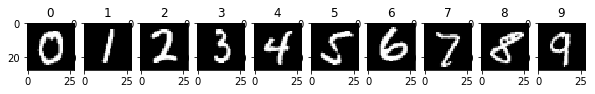

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

# Split data into train and test set 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels)

# RandomForestClassifier with PCA

In [8]:
experiment_id = mlflow.create_experiment("RandomForestClassifier")
print("Experiment id: %d" % experiment_id)

Experiment id: 1


In [9]:
print(experiment_id)

1


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees = 100
cv = 7
criterion = "gini"    
pca_components = 50

with mlflow.start_run(experiment_id=experiment_id):

    # PCA
    pca = PCA(n_components=pca_components, random_state=random_state)
    pca_fit = pca.fit(X_train)
    X_train_pca = pca_fit.transform(X_train)
    X_test_pca = pca_fit.transform(X_test)
    
    # Cross validation
    clf = RandomForestClassifier(n_estimators=n_trees, criterion=criterion, random_state=random_state, n_jobs=-1)
    scores = cross_val_score(clf, X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    #Test 
    clf.fit(X_train_pca, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees", n_trees)
    mlflow.log_param("cv", cv)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("pca_components", pca_components)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

Accuracy on cross-validation set: 0.9480 (+/- 0.0042)
Accuracy on test set: 0.9481


# GradientBoostingClassifier with PCA

In [ ]:
experiment_id = mlflow.create_experiment("GradientBoostingClassifier")
print("Experiment id: %d" % experiment_id)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees = 12
cv = 7
max_depth = 3
pca_components = 100

with mlflow.start_run(experiment_id=experiment_id):
    
    # PCA
    pca = PCA(n_components=pca_components, random_state=random_state)
    pca_fit = pca.fit(X_train)
    X_train_pca = pca_fit.transform(X_train)
    X_test_pca = pca_fit.transform(X_test)
    
    # Cross-Validation
    clf = GradientBoostingClassifier(n_estimators=n_trees,random_state=random_state, max_depth=max_depth)
    
    scores = cross_val_score(clf, X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    # Test
    clf.fit(X_train_pca, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees", n_trees)
    mlflow.log_param("cv", cv)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("pca_components", pca_components)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

# Cascading

In [24]:
def append_cols(l):    
    return np.column_stack(l)

In [ ]:
experiment_id = mlflow.create_experiment("Stacking on RandomForestClassifier")
print("Experiment id: %d" % experiment_id)

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, n_values=n_classes)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees_n1 = 100
n_trees_n2 = 25
max_depth_n2 = 5
cv = 7
criterion = "gini"
pca_components = 100

with mlflow.start_run(experiment_id=experiment_id):
    
    # PCA
    pca = PCA(n_components=pca_components, random_state=random_state)
    pca_fit = pca.fit(X_train)
    X_train_pca = pca_fit.transform(X_train)
    X_test_pca = pca_fit.transform(X_test)

    # Stacking
    
    clf = RandomForestClassifier(n_estimators=n_trees_n1, criterion=criterion, random_state=random_state, n_jobs=-1)
    clf.fit(X_train_pca, y_train)
    
    train_probs = clf.predict_proba(X_train_pca)
    y_train_enc = enc.fit_transform(y_train.reshape(-1,1))
    
    tests_probs = clf.predict_proba(X_test_pca)
    y_test_predicted = clf.predict(X_test_pca)
    y_test_enc = enc.fit_transform(y_test_predicted.reshape(-1,1))
    
    new_X_train_pca = append_cols([X_train_pca, y_train_enc, train_probs])
    new_X_test_pca = append_cols([X_test_pca, y_test_enc, tests_probs])
    
    # Train
    clf = GradientBoostingClassifier(n_estimators=n_trees_n2,random_state=random_state, max_depth=max_depth_n2)
    scores = cross_val_score(clf, new_X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    
    # Test    
    clf = GradientBoostingClassifier(n_estimators=n_trees_n2,random_state=random_state, max_depth=max_depth_n2)
    clf.fit(new_X_train_pca, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(new_X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees_n1", n_trees_n1)
    mlflow.log_param("n_trees_n2", n_trees_n2)
    mlflow.log_param("max_depth_n2", max_depth_n2)
    mlflow.log_param("cv", cv)
    mlflow.log_param("pca_components", pca_components)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7efe492c1f60, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/cs4r/.local/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/cs4r/.local/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/cs4r/..../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7efe492c1f60, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/cs4r/.local/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/cs4r/.local/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/cs4r/..../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method PollIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/lib/python3/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    861                 self._events.update(event_pairs)
    862                 while self._events:
    863                     fd, events = self._events.popitem()
    864                     try:
    865                         fd_obj, handler_func = self._handlers[fd]
--> 866                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    867                     except (OSError, IOError) as e:
    868                         if errno_from_exception(e) == errno.EPIPE:
    869                             # Happens when the client closes the connection
    870                             pass

...........................................................................
/usr/lib/python3/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/usr/lib/python3/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 16, 21, 31, 38, 384247, tzinfo=tzutc()), 'msg_id': 'b4e6bc01fc04416683b89a99879c8e70', 'msg_type': 'execute_request', 'session': '772ee5295c114298a0a795214a407846', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'b4e6bc01fc04416683b89a99879c8e70', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'772ee5295c114298a0a795214a407846']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 16, 21, 31, 38, 384247, tzinfo=tzutc()), 'msg_id': 'b4e6bc01fc04416683b89a99879c8e70', 'msg_type': 'execute_request', 'session': '772ee5295c114298a0a795214a407846', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'b4e6bc01fc04416683b89a99879c8e70', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'772ee5295c114298a0a795214a407846'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 16, 21, 31, 38, 384247, tzinfo=tzutc()), 'msg_id': 'b4e6bc01fc04416683b89a99879c8e70', 'msg_type': 'execute_request', 'session': '772ee5295c114298a0a795214a407846', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'b4e6bc01fc04416683b89a99879c8e70', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.With object>], cell_name='<ipython-input-18-cb12dd3d9c0d>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7efddbf31d68, executi...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7efdda4d0270, file "<ipython-input-18-cb12dd3d9c0d>", line 12>
        result = <ExecutionResult object at 7efddbf31d68, executi...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/home/cs4r/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7efdda4d0270, file "<ipython-input-18-cb12dd3d9c0d>", line 12>, result=<ExecutionResult object at 7efddbf31d68, executi...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7efdda4d0270, file "<ipython-input-18-cb12dd3d9c0d>", line 12>
        self.user_global_ns = {'In': ['', "import pandas as pd\nimport numpy as np\nimport ml..._ipython().run_line_magic('matplotlib', 'inline')", 'random_state = 2018', 'np.random.seed(random_state)', "data = pd.read_csv('./data/train.csv', low_memory=False, skiprows=0)", 'images = data.loc[:, data.columns != "label"].va...mensionality of labels: {}".format(labels.shape))', 'import matplotlib.pyplot as plt\nget_ipython().ru...\n    ax[i].set_title("{}".format(labels_text[i]))', 'from sklearn.model_selection import train_test_s...t(images, labels, test_size=0.1, stratify=labels)', 'experiment_id = mlflow.create_experiment("Random...fier")\nprint("Experiment id: %d" % experiment_id)', 'print(experiment_id)', 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', '# Once we have found the best parameters, generate predictions for test data', 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', '# Once we have found the best parameters, generate predictions for test data', "test_data = pd.read_csv('./data/test.csv', low_memory=False, skiprows=0)", '# PCA\npca = PCA(n_components=pca_components, ran...a = pca.fit_transform(test_data)\ny_train = labels', '# Stacking\n\n# First round: RandomForest\nclf1 = R..., y_train)\n\ny_pred = clf2.predict(new_X_test_pca)', 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")'], 'Out': {}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X_test': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,..., ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'X_test_pca': array([[-5.61767790e+02,  6.34820560e+02, -1.986...67201774e+01, -2.79350691e+01, -1.28443718e+01]]), 'X_train': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,..., ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'X_train_pca': array([[-1.09793376e+02, -6.19064303e+02, -1.096...60892576e+00,  5.39742056e+01,  1.06477312e+02]]), '_': '', '__': '', ...}
        self.user_ns = {'In': ['', "import pandas as pd\nimport numpy as np\nimport ml..._ipython().run_line_magic('matplotlib', 'inline')", 'random_state = 2018', 'np.random.seed(random_state)', "data = pd.read_csv('./data/train.csv', low_memory=False, skiprows=0)", 'images = data.loc[:, data.columns != "label"].va...mensionality of labels: {}".format(labels.shape))', 'import matplotlib.pyplot as plt\nget_ipython().ru...\n    ax[i].set_title("{}".format(labels_text[i]))', 'from sklearn.model_selection import train_test_s...t(images, labels, test_size=0.1, stratify=labels)', 'experiment_id = mlflow.create_experiment("Random...fier")\nprint("Experiment id: %d" % experiment_id)', 'print(experiment_id)', 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', '# Once we have found the best parameters, generate predictions for test data', 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")', '# Once we have found the best parameters, generate predictions for test data', "test_data = pd.read_csv('./data/test.csv', low_memory=False, skiprows=0)", '# PCA\npca = PCA(n_components=pca_components, ran...a = pca.fit_transform(test_data)\ny_train = labels', '# Stacking\n\n# First round: RandomForest\nclf1 = R..., y_train)\n\ny_pred = clf2.predict(new_X_test_pca)', 'from sklearn.ensemble import RandomForestClassif...)\n    \n    mlflow.sklearn.log_model(clf, "model")'], 'Out': {}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X_test': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,..., ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'X_test_pca': array([[-5.61767790e+02,  6.34820560e+02, -1.986...67201774e+01, -2.79350691e+01, -1.28443718e+01]]), 'X_train': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,..., ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'X_train_pca': array([[-1.09793376e+02, -6.19064303e+02, -1.096...60892576e+00,  5.39742056e+01,  1.06477312e+02]]), '_': '', '__': '', ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/home/cs4r/digit-recognizer-mlflow/<ipython-input-18-cb12dd3d9c0d> in <module>()
     18     X_test_pca = pca_fit.transform(X_test)
     19 
     20     # Stacking
     21     
     22     clf = RandomForestClassifier(n_estimators=n_trees_n1, criterion=criterion, random_state=random_state, n_jobs=-1)
---> 23     clf.fit(X_train_pca, y_train)
     24     
     25     train_probs = clf.predict_proba(X_train_pca)
     26     y_train_enc = enc.fit_transform(y_train.reshape(-1,1))
     27     

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...te=2018, verbose=0,
            warm_start=False), X=array([[-1.0979337e+02, -6.1906433e+02, -1.09678...  5.3974205e+01,  1.0647731e+02]], dtype=float32), y=array([[1.],
       [0.],
       [1.],
       ...,
       [7.],
       [6.],
       [9.]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 99
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Jun 16 22:31:41 2018
PID: 30530                                   Python 3.5.2: /usr/bin/python3
...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeClassifier(class_weight=None, criter...        random_state=1642177786, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...te=2018, verbose=0,
            warm_start=False), array([[-1.0979337e+02, -6.1906433e+02, -1.09678...  5.3974205e+01,  1.0647731e+02]], dtype=float32), array([[1.],
       [0.],
       [1.],
       ...,
       [7.],
       [6.],
       [9.]]), None, 0, 100), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeClassifier(class_weight=None, criter...        random_state=1642177786, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...te=2018, verbose=0,
            warm_start=False), array([[-1.0979337e+02, -6.1906433e+02, -1.09678...  5.3974205e+01,  1.0647731e+02]], dtype=float32), array([[1.],
       [0.],
       [1.],
       ...,
       [7.],
       [6.],
       [9.]]), None, 0, 100)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=DecisionTreeClassifier(class_weight=None, criter...        random_state=1642177786, splitter='best'), forest=RandomForestClassifier(bootstrap=True, class_wei...te=2018, verbose=0,
            warm_start=False), X=array([[-1.0979337e+02, -6.1906433e+02, -1.09678...  5.3974205e+01,  1.0647731e+02]], dtype=float32), y=array([[1.],
       [0.],
       [1.],
       ...,
       [7.],
       [6.],
       [9.]]), sample_weight=None, tree_idx=0, n_trees=100, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeClassifier.fit of Deci...       random_state=1642177786, splitter='best')>
        X = array([[-1.0979337e+02, -6.1906433e+02, -1.09678...  5.3974205e+01,  1.0647731e+02]], dtype=float32)
        y = array([[1.],
       [0.],
       [1.],
       ...,
       [7.],
       [6.],
       [9.]])
        sample_weight = None
        curr_sample_weight = array([1., 1., 1., ..., 1., 0., 0.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...        random_state=1642177786, splitter='best'), X=array([[-1.0979337e+02, -6.1906433e+02, -1.09678...  5.3974205e+01,  1.0647731e+02]], dtype=float32), y=array([[1.],
       [0.],
       [1.],
       ...,
       [7.],
       [6.],
       [9.]]), sample_weight=array([1., 1., 1., ..., 1., 0., 0.]), check_input=False, X_idx_sorted=None)
    785 
    786         super(DecisionTreeClassifier, self).fit(
    787             X, y,
    788             sample_weight=sample_weight,
    789             check_input=check_input,
--> 790             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
    791         return self
    792 
    793     def predict_proba(self, X, check_input=True):
    794         """Predict class probabilities of the input samples X.

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...        random_state=1642177786, splitter='best'), X=array([[-1.0979337e+02, -6.1906433e+02, -1.09678...  5.3974205e+01,  1.0647731e+02]], dtype=float32), y=array([[1.],
       [0.],
       [1.],
       ...,
       [7.],
       [6.],
       [9.]]), sample_weight=array([1., 1., 1., ..., 1., 0., 0.]), check_input=False, X_idx_sorted=None)
    231 
    232         self.max_features_ = max_features
    233 
    234         if len(y) != n_samples:
    235             raise ValueError("Number of labels=%d does not match "
--> 236                              "number of samples=%d" % (len(y), n_samples))
        y = array([[1.],
       [0.],
       [1.],
       ...,
       [7.],
       [6.],
       [9.]])
        n_samples = 37800
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")

ValueError: Number of labels=42000 does not match number of samples=37800
___________________________________________________________________________

# Generate test predictions

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


### Once we have found the best parameters, we generate predictions for test data

In [15]:
test_data = pd.read_csv('./data/test.csv', low_memory=False, skiprows=0)

In [44]:
ImageId=list(range(1,test_data.shape[0]+1))

In [19]:
# PCA
pca = PCA(n_components=pca_components, random_state=random_state)
pca.fit(images)
X_train_pca = pca.fit_transform(images)
X_test_pca = pca.fit_transform(test_data)
y_train = labels

In [27]:
# Stacking

# First round: RandomForest
clf1 = RandomForestClassifier(n_estimators=n_trees_n1, criterion=criterion, random_state=random_state, n_jobs=-1)
clf1.fit(X_train_pca, labels)

train_probs = clf1.predict_proba(X_train_pca)
y_train_enc = enc.fit_transform(y_train.reshape(-1,1))

test_probs = clf1.predict_proba(X_test_pca)
y_test_predicted = clf1.predict(X_test_pca)
y_test_enc = enc.fit_transform(y_test_predicted.reshape(-1,1))

new_X_train_pca = np.column_stack((X_train_pca, y_train_enc, train_probs))
new_X_test_pca = np.column_stack((X_test_pca, y_test_enc, test_probs))

# Second round: Boosting
clf2 = GradientBoostingClassifier(n_estimators=n_trees_n2,random_state=random_state, max_depth=max_depth_n2)
clf2.fit(new_X_train_pca, y_train)

y_pred = clf2.predict(new_X_test_pca)

In [46]:
results = np.column_stack((ImageId,y_pred))

In [47]:
np.savetxt("predictions.txt",results,fmt='%i,%i',header='ImageId,Label',comments='')